In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from keras.utils import to_categorical
from keras.models import Model, Sequential
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import h5py
from matplotlib import pyplot as plt
from PIL import Image
from time import time
import logging#程序进展信息
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split#分割数据集
#from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people#下载数据集
from sklearn.model_selection import GridSearchCV
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA
from sklearn.svm import SVC

Using TensorFlow backend.


In [2]:
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [3]:
num_classes = len(emotion_labels)

In [4]:
fer_data = h5py.File('./data.h5', 'r', driver='core')

In [5]:
fer_x = np.asarray(fer_data['Training_pixel']).reshape((28709, 48*48))

In [6]:
fer_y = fer_data['Training_label']

In [7]:
X_train = fer_x

In [8]:
X_test_public=np.asarray(fer_data['PublicTest_pixel']).reshape((3589,48*48))

In [9]:
X_test_private=np.asarray(fer_data['PrivateTest_pixel']).reshape((3589,48*48))

In [10]:
num_train = X_train.shape[0]

In [11]:
num_val_public=X_test_public.shape[0]

In [12]:
num_val_private=X_test_private.shape[0]

In [13]:
print('Training: ',X_train.shape)

Training:  (28709, 2304)


In [14]:
print('PublicTest:',X_test_public.shape)

PublicTest: (3589, 2304)


In [15]:
print('PrivateTest:',X_test_private.shape)

PrivateTest: (3589, 2304)


In [16]:
Y_train = fer_data['Training_label']

In [17]:
Y_train = to_categorical(Y_train, num_classes)

In [18]:
Y_test_public=fer_data['PublicTest_label']

In [19]:
Y_test_private=fer_data['PrivateTest_label']

In [20]:
Y_test_public=to_categorical(Y_test_public,num_classes)

In [21]:
Y_test_private=to_categorical(Y_test_private,num_classes)

In [22]:
print('Training:',Y_train.shape)

Training: (28709, 7)


In [23]:
print('PublicTest:',Y_test_public.shape)

PublicTest: (3589, 7)


In [24]:
print('PrivateTest:',Y_test_private.shape)

PrivateTest: (3589, 7)


In [25]:
n_components = 64

In [26]:
pca =PCA(svd_solver='randomized',n_components=n_components,whiten=True).fit(X_train)#降低维度

In [27]:
X_train_pca = pca.transform(X_train)      #得到训练集投影系数

In [28]:
X_val_pca_public = pca.transform(X_test_public)

In [29]:
X_val_pca_private = pca.transform(X_test_private)

In [30]:
print(X_train_pca.shape)

(28709, 64)


In [31]:
print(X_val_pca_public.shape)

(3589, 64)


In [32]:
print(X_val_pca_private.shape)

(3589, 64)


In [33]:
eigenfaces = pca.components_.reshape((n_components, 48, 48))

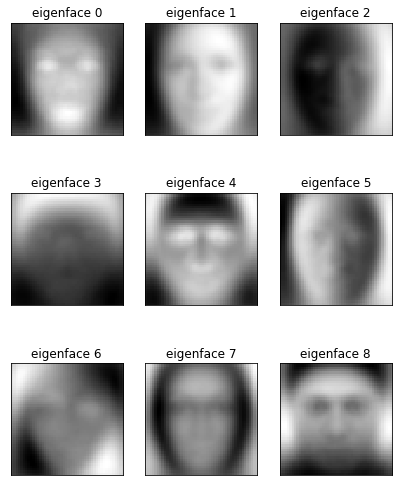

In [34]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=3):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
 
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, 48, 48)
plt.show()

In [35]:
y_train_ = np.argmax(Y_train, axis=-1)

In [36]:
y_train_.shape

(28709,)

In [37]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3],
              'gamma': [0.001], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca[:5000], y_train_[:5000])
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


done in 39.969s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [38]:
print("Predicting people's emotions on the test set")
t0 = time()
y_pred_public= clf.predict(X_val_pca_public)
y_pred_private= clf.predict(X_val_pca_private)
print("done in %0.3fs" % (time() - t0))
y_val_public = np.argmax(Y_test_public, axis=-1)
y_val_private = np.argmax(Y_test_private, axis=-1)
print(classification_report(y_val_public, y_pred_public))
print(confusion_matrix(y_val_public, y_pred_public, labels=range(num_classes)))

Predicting people's emotions on the test set
done in 3.319s
              precision    recall  f1-score   support

           0       0.23      0.33      0.27       467
           1       0.18      0.12      0.15        56
           2       0.20      0.21      0.20       496
           3       0.53      0.54      0.54       895
           4       0.30      0.26      0.28       653
           5       0.52      0.44      0.48       415
           6       0.35      0.31      0.33       607

    accuracy                           0.36      3589
   macro avg       0.33      0.32      0.32      3589
weighted avg       0.37      0.36      0.36      3589

[[153   3  73  93  70  18  57]
 [ 13   7  11  13   5   1   6]
 [104   8 104  83  80  47  70]
 [121   9  71 485  94  27  88]
 [130   9 110 107 169  35  93]
 [ 37   0  82  34  45 182  35]
 [113   2  74  97  95  40 186]]


In [39]:
print(classification_report(y_val_private, y_pred_private))
print(confusion_matrix(y_val_private, y_pred_private, labels=range(num_classes)))

              precision    recall  f1-score   support

           0       0.24      0.30      0.27       491
           1       0.20      0.13      0.16        55
           2       0.27      0.28      0.28       528
           3       0.53      0.53      0.53       879
           4       0.27      0.26      0.27       594
           5       0.47      0.41      0.44       416
           6       0.37      0.34      0.35       626

    accuracy                           0.36      3589
   macro avg       0.34      0.32      0.33      3589
weighted avg       0.37      0.36      0.37      3589

[[147   7  71  74  92  31  69]
 [  9   7   8  15   7   2   7]
 [ 82   4 150  68  90  61  73]
 [109  10  80 464  90  34  92]
 [125   3  86 104 157  32  87]
 [ 43   2  82  43  39 170  37]
 [103   2  72 101 104  34 210]]
